Load the data

In [2]:
import pandas as pd
import sys
sys.path.append(r'C:\Users\Surface\Masterarbeit')
#import matplotlib.pyplot as plt

#%matplotlib inline

path = r"C:\Users\Surface\Masterarbeit\data\Produktionsdaten\WZ_2_Feature_Engineered_Fynn6.xlsx"

df = pd.read_excel(path)

Data Preprocessing to compare the algorithms, although Decision Trees are not sensitve to feature scalling, they do not use geometric distances


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import prep
import importlib
importlib.reload(prep)

# set the target variable
target = 'C1_V01_delta_kan'
#print(df.columns)
# get the numerical features
data_num = df.drop(['C1_V01_delta_kan'], axis = 1, inplace=False)
#print(data_num.columns)
# get the target values
data_labels = df[target].to_numpy()

# split the data into training, validation and test sets
# 60% training, 20%, validation, 20% test
X_temp, X_test_prep, y_temp, y_test = train_test_split(data_num, data_labels, test_size= 0.2, random_state=42)
X_train_prep, X_val_prep, y_train, y_val = train_test_split(X_temp, y_temp, test_size= 0.25, random_state=42)

# use coustom function "cat_transform" from prep.py to map the categorical features with their frequencies
X_train_prep, X_val_prep, X_test_prep = prep.cat_transform(X_train_prep, X_val_prep, X_test_prep, ['BT_NR', 'STP_NR'])
print(X_train_prep.columns)

# pipeline for preprocessing the data
# Standard Scaler for distribution with 0 mean and 1 std., normal distributed data
data_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
# get the feature names after preprocessing for the feature importance
feature_names = X_train_prep.columns

# fit the pipeline to the data and transform it
X_train = data_pipeline.fit_transform(X_train_prep)
X_val = data_pipeline.transform(X_val_prep)
X_test = data_pipeline.transform(X_test_prep)

# print the shapes of the data
print(data_num.shape, X_train.shape, X_val.shape, X_test.shape)

Index(['Ist_Blechhaltergewicht', 'Ist_Gegenhaltekraft_HL_1', 'T2', 'K1', 'T20',
       'K7', 'T23', 'K8', 'DS_10', 'GS_10', 'SD_10', 'LS_10', 'PP_10', 'TT_10',
       'TM5_10', 'RF_10', 'TD_10', 'is_weekend', 'dayofweek_sin',
       'dayofweek_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'quarter_sin', 'quarter_cos', 'week_sin',
       'week_cos', 'Diff_Hubzahl', 'Diff_Ziehtiefe',
       'Diff_Ziehkissenverstellu', 'Diff_Stoesselverstellung-mm',
       'Diff_Gewichtsausgleich', 'BT_NR_freq', 'STP_NR_freq'],
      dtype='object')
(52011, 37) (31206, 37) (10402, 37) (10403, 37)


NGBoost for outputting Probalitiy Distribution instead of single value https://stanfordmlgroup.github.io/ngboost/1-useage.html

In [4]:
# necessary imports for NGBoost
from ngboost import NGBRegressor
from ngboost.scores import LogScore
from ngboost.distns import  Normal
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error


Eigene Loop für Grid Search, um mit einem festen Val Set zu arbeiten und dann Early Stopping implementieren, GridSearchCV nur mit Cross Validation und ohne Early Stopping möglich von sklearn

In [ ]:
# define the hyperparameter grid    
param_grid = {
    'n_estimators': [ 200, 400, 600],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [6, 8, 10, 12, 14],
}

best_score = float('inf')
best_params = None
scores = []
# Loop through all combinations of hyperparameters
for max_depth in param_grid['max_depth']:
    for n_estimators in param_grid['n_estimators']:
        for learning_rate in param_grid['learning_rate']:# 
            # Create a new NGBRegressor with the current hyperparameters
            ngb = NGBRegressor(
                Dist=Normal, 
                Score=LogScore, 
                Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=max_depth),
                verbose=True, 
                n_estimators=n_estimators, 
                learning_rate=learning_rate
            )
            
            # Fit the model to the training data
            ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=20)
            
            # Make predictions on the validation set
            y_preds = ngb.predict(X_val)
            y_dists = ngb.pred_dist(X_val)
            
            # Calculate the mean squared error
            mse = mean_squared_error(y_val, y_preds)
            
            # Calculate R²
            r2 = r2_score(y_val, y_preds)
        
            # Calculate the negative log likelihood
            # Note: The logpdf method returns the log probability density function
            # for the predicted distribution at the given values
            nll = -y_dists.logpdf(y_val).mean()
            
            # Print the results            
            print(f"n_estimators: {n_estimators}, learning_rate: {learning_rate}, max_depth: {max_depth}, MSE: {mse:.3f}, R²: {r2:.3f}, Negative Log Likelihood: {nll:.3f}")
            
            # log the scores
            scores.append({
                'n_estimators': n_estimators,
                'learning_rate': learning_rate,
                'max_depth': max_depth,
                'mse': mse,
                'r2': r2,
                'nll': nll
            })
            # Check if this is the best score so far
            if nll < best_score:
                best_score = nll
                best_params = {
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth
                }
     

In [ ]:
# get the best parameters, lists for nll, R2 and MSE
# list contains at each position a list element with the score and the parameters dictonary
negLL = []
r2_lst = []
mse = []
for s in scores:
    mse.append([s['mse'],s])
    r2_lst.append([s['r2'],s])
    negLL.append([s['nll'],s])

print(f"best negativ log likelyhood {min(negLL)}")
print(f" best R2-Score {max(r2_lst)}")
print(f" best MSE {min(mse)}")

Just one implemantation to test the parameter

In [5]:
# first choice: normal distribution
# default base learner is a depth 3 decision tree
# LogScore for negative log likelihood
# create the model with the best parameters

ngb = NGBRegressor(Dist=Normal, 
                   Score = LogScore, 
                   Base = DecisionTreeRegressor(criterion='friedman_mse' , max_depth=8), 
                   verbose = True, 
                   n_estimators=600, 
                   learning_rate=0.01)
# fit the model to the training data, early stopping on validation set after 20 rounds without improvement
ngb.fit(X_train, y_train, X_val=X_val, Y_val=y_val, early_stopping_rounds=20)

[iter 0] loss=3.4547 val_loss=3.4308 scale=1.0000 norm=6.1507
[iter 100] loss=2.6678 val_loss=2.6912 scale=2.0000 norm=5.0644
[iter 200] loss=2.2725 val_loss=2.3854 scale=2.0000 norm=4.0341
== Early stopping achieved.
== Best iteration / VAL270 (val_loss=2.3444)


NGBRegressor(Base=DecisionTreeRegressor(criterion='friedman_mse', max_depth=8),
             n_estimators=600,
             random_state=RandomState(MT19937) at 0x256A03A4340)

nll_train: 2.137
Train MSE: 5.643
R² on Train Data: 0.904
nll_test: 2.328
Test MSE: 7.742
R² on Test Data: 0.864
Coverage: 94.00%


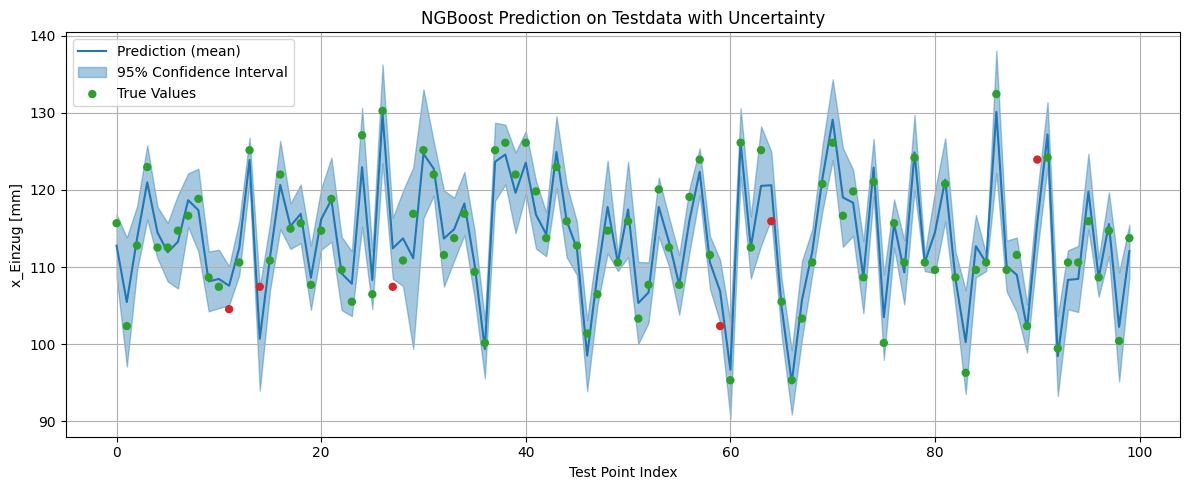

In [6]:
import numpy as np
import matplotlib.pyplot as plt
#import wandb
#wandb.login()

#! handling the train data
# Predicte mean and distribution for train and test data
y_train_preds = ngb.predict(X_train)
y_train_dists = ngb.pred_dist(X_train)

# print the negative log likelihood
print(f"nll_train: {-y_train_dists.logpdf(y_train).mean():.3f}")
# calculate the mean squared error
mse_train = mean_squared_error(y_train, y_train_preds)
print(f"Train MSE: {mse_train:.3f}")
# Calculate R² for the train data
r2_train = r2_score(y_train, y_train_preds)
print(f"R² on Train Data: {r2_train:.3f}")


#! handling the test data
# Select a random subset of test data for visualization
num_points = 100
np.random.seed(42)

random_indices = np.random.choice(len(X_test), num_points, replace=False)
random_indices.sort()

# Predict mean and distribution for test data
y_test_preds = ngb.predict(X_test)
y_test_dists = ngb.pred_dist(X_test)
# Extract standard deviation from test predictions
test_stddev = y_test_dists.scale

# print the negative log likelihood
print(f"nll_test: {-y_test_dists.logpdf(y_test).mean():.3f}")
# calculate the mean squared error
mse_test = mean_squared_error(y_test, y_test_preds)
print(f"Test MSE: {mse_test:.3f}")
# Calculate R² for the test data
r2_test = r2_score(y_test, y_test_preds)
print(f"R² on Test Data: {r2_test:.3f}")

# Define the confidence interval bounds (95% CI ≈ mean ± 2*std)
ngboost_lower = y_test_preds[random_indices] - 2*test_stddev[random_indices]
ngboost_upper = y_test_preds[random_indices] + 2*test_stddev[random_indices]

# Check whether each true value lies within the 95% confidence interval
# If yes, the point will be green; if not, red
in_interval = (y_test[random_indices] >= ngboost_lower) & (y_test[random_indices] <= ngboost_upper)
colors = ['tab:green' if inside else 'tab:red' for inside in in_interval]

# Calculate coverage (percentage of true values within the CI)
coverage = np.mean(in_interval) * 100  # in percentage

# Print the coverage value
print(f"Coverage: {coverage:.2f}%")

# Plotting the prediction with uncertainty and true values
fig = plt.figure(figsize=(12, 5))
x_axis = np.arange(num_points)

# Plot predicted mean
plt.plot(x_axis, y_test_preds[random_indices], label="Prediction (mean)", color='tab:blue')

# Shade the 95% confidence interval (±2 standard deviations)
plt.fill_between(x_axis, ngboost_lower, ngboost_upper,
                 alpha=0.4, color='tab:blue', label='95% Confidence Interval')

# Plot true target values as orange dots
plt.scatter(x_axis, y_test[random_indices], label="True Values", c=colors, s=25, zorder=3)

# Add plot labels and formatting
plt.title("NGBoost Prediction on Testdata with Uncertainty")
plt.xlabel("Test Point Index")
plt.ylabel("x_Einzug [mm]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# wandb.init(project="ngboost-fem-rauschen", config={
#     "n_estimators": 400,
#     "learning_rate": 0.01,
#     "distribution": "Normal",
#     "score": "LogScore",
#     "early_stopping_rounds": 2,
#     })

# wandb.log({"coverage": coverage})
# wandb.log({"R²": r2_test})
# wandb.log({"confidence_interval_plot": wandb.Image(fig)})

Overview on the feature importance

                        feature  importance
30                 Diff_Hubzahl    0.009826
31               Diff_Ziehtiefe    0.008202
1      Ist_Gegenhaltekraft_HL_1    0.006987
33  Diff_Stoesselverstellung-mm    0.005230
34       Diff_Gewichtsausgleich    0.004091
10                        SD_10    0.002766
19                dayofweek_cos    0.002592
18                dayofweek_sin    0.002206
32     Diff_Ziehkissenverstellu    0.000758
21                    month_cos    0.000668
27                  quarter_cos    0.000253
20                    month_sin    0.000179
26                  quarter_sin    0.000137
17                   is_weekend    0.000039
0        Ist_Blechhaltergewicht    0.000010
                     feature  importance
1   Ist_Gegenhaltekraft_HL_1    0.009826
21                 month_cos    0.008346
10                     SD_10    0.006546
28                  week_sin    0.004669
24                   day_sin    0.004202
20                 month_sin    0.004180
34    Dif

Text(0.5, 1.0, 'std (scale param)')

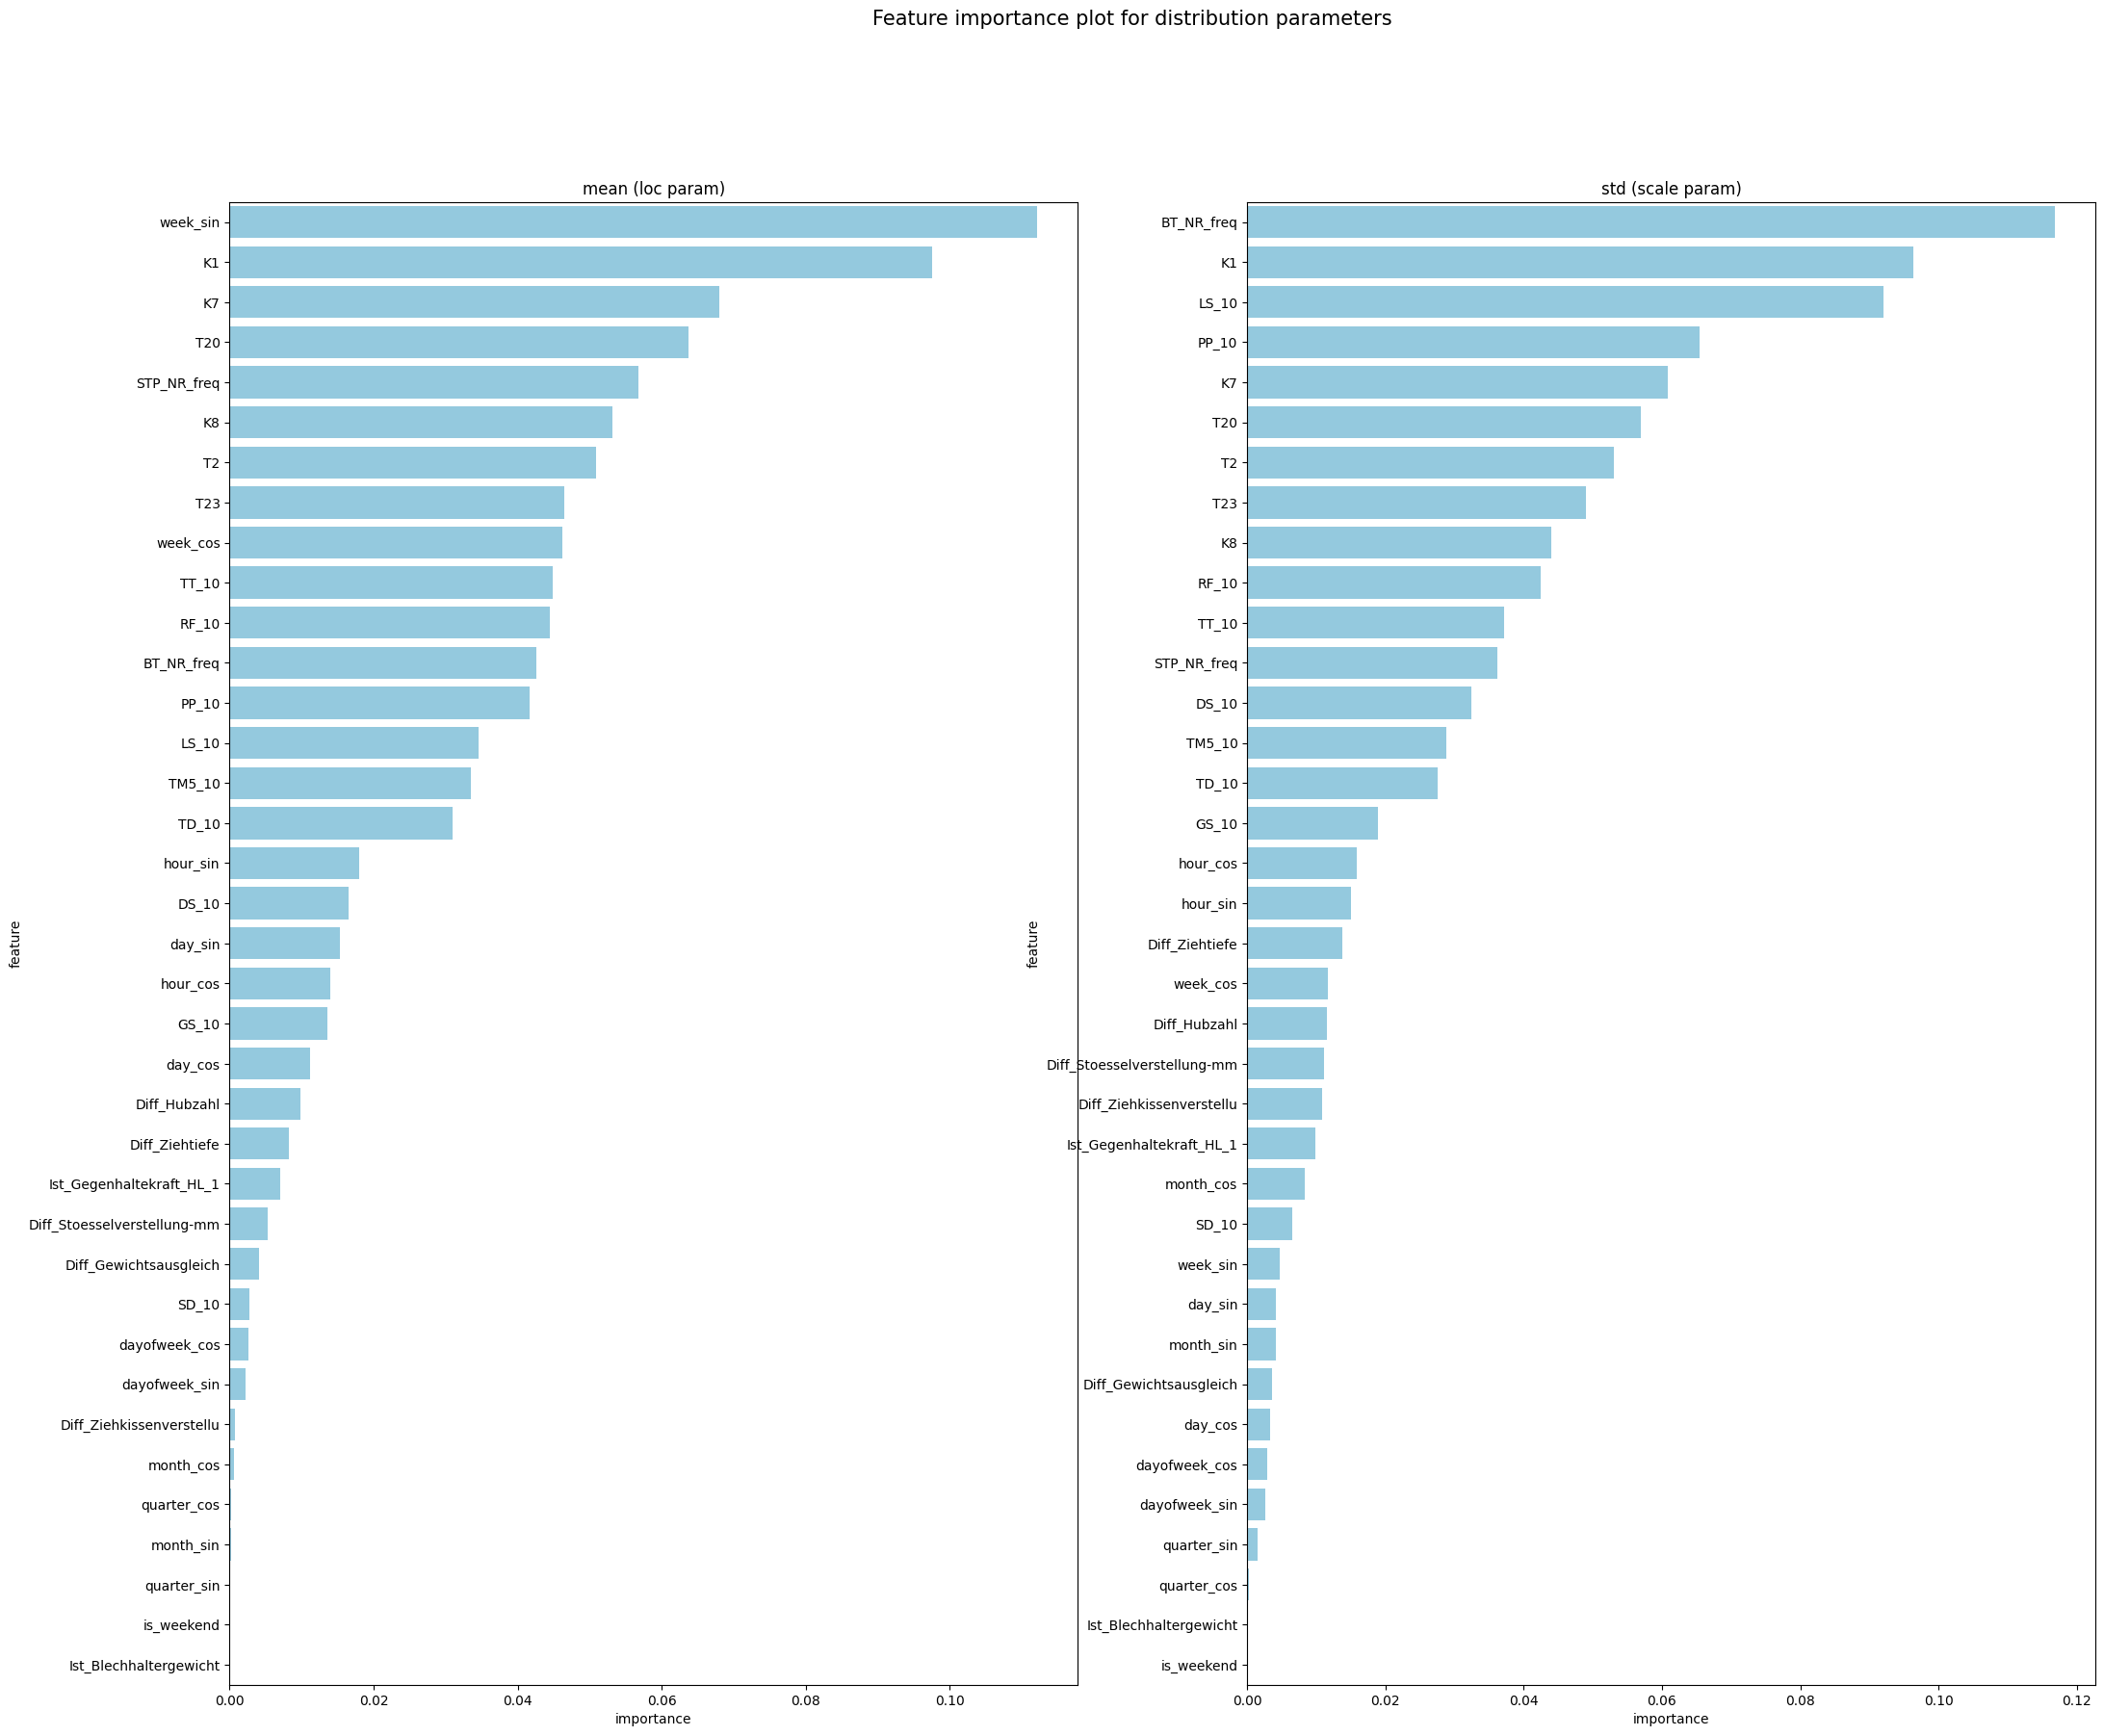

In [7]:
import seaborn as sns
## Feature importance for loc trees
feature_importance_loc = ngb.feature_importances_[0]

## Feature importance for scale trees
feature_importance_scale = ngb.feature_importances_[1]

#feature names baseline dataset
#['Matrizenradius [mm ]', 'Stempelkantenradius [mm]', 'Blechdicke [mm]',            'Platinenabmessung [mm]', '1/4 Niederhalterkraft [N]', 'Ziehtiefe [mm]']

df_loc = pd.DataFrame({
                        'feature':feature_names,
                        'importance':feature_importance_loc})\
                        .sort_values('importance',ascending=False)
    
df_scale = pd.DataFrame({
                        'feature':feature_names,
                        'importance':feature_importance_scale})\
                        .sort_values('importance',ascending=False)

df_loc_filtered = df_loc[df_loc['importance'] < 0.01]
df_scale_filtered = df_scale[df_scale['importance'] < 0.01]

print(df_loc_filtered)
print(df_scale_filtered)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,20))
fig.suptitle("Feature importance plot for distribution parameters", fontsize=15)
sns.barplot(x='importance',y='feature',ax=ax1,data=df_loc, color="skyblue").set_title('mean (loc param)')
sns.barplot(x='importance',y='feature',ax=ax2,data=df_scale, color="skyblue").set_title('std (scale param)')

Permutation Importance

Wie stark sinkt die Modell-Performance, wenn ein Feature zufällig durchmischt (permutiert) wird

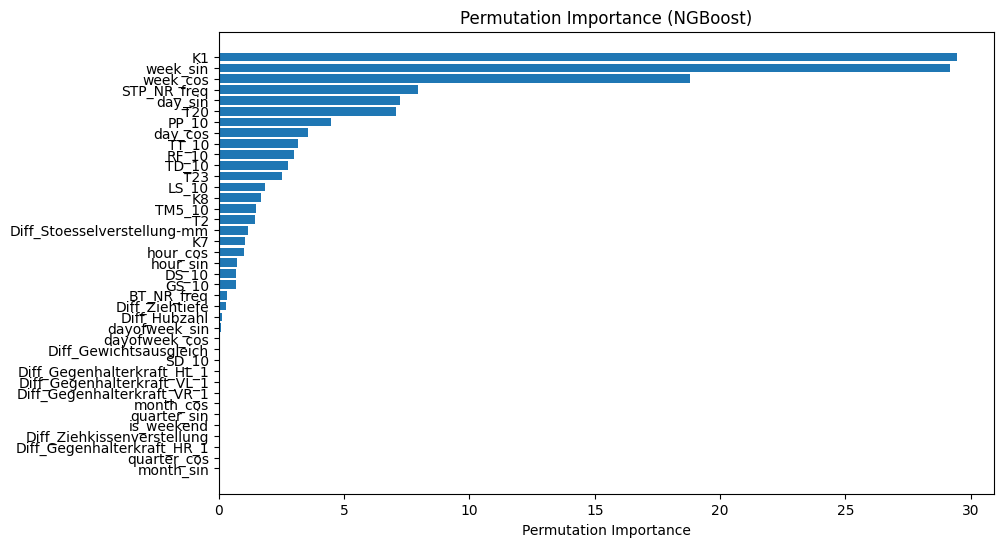

In [8]:
from sklearn.inspection import permutation_importance

result = permutation_importance(ngb, X_test, y_test, n_repeats=10, random_state=42, scoring = 'neg_mean_squared_error')

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10,6))
plt.barh(np.array(feature_names)[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Permutation Importance (NGBoost)")
plt.show()


SHAP Interpretation:
„Wie viel trägt jedes Feature zur Abweichung der Vorhersage vom Durchschnitt bei?“

Dazu berechnet SHAP für jedes Feature und jeden Datenpunkt einen Wert, den SHAP-Wert, der quantifiziert:

positiver SHAP-Wert → dieses Feature hat die Vorhersage erhöht

negativer SHAP-Wert → dieses Feature hat die Vorhersage gesenkt

C:\Users\Surface\AppData\Local\Temp\ipykernel_18564\18836053.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train, feature_names=feature_names, max_display=10)


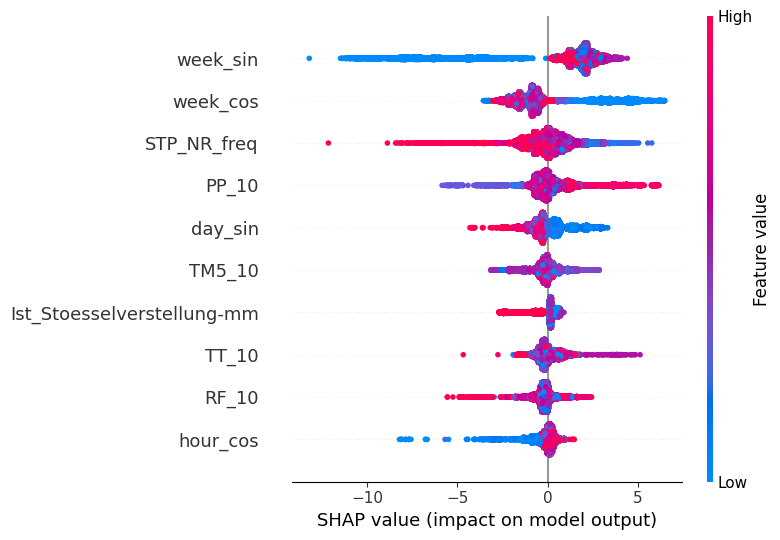

In [40]:
import shap
shap.initjs()

## SHAP plot for loc trees
explainer = shap.TreeExplainer(ngb, model_output=0) # use model_output = 1 for scale trees
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, feature_names=feature_names, max_display=10)